# <center> <font color = "#ef4155"> **Classifiez automatiquement des biens de consommation**

## <font color = "#ef4155"> **Description du projet :** <br>
<font color = "black"> L'entreprise "**Place de marché**”, souhaite lancer une marketplace e-commerce. A cet effet, elle veut rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser l'attribution de la catégorie d'un article. <br> 

Pour accompagner l'entreprise dans cette démarche, ma mission consiste à étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant. 

## <font color = "#ef4155"> **Protocole d'étude :** <br>
<font color = "black"> Pour réaliser cette mission visant à étudier la faisabilité d'un moteur de classification d'articles basé sur une image et une description, je vais suivre les étapes suivantes :

1. **Collecte et préparation des données** : Rassembler les données comprenant des images et des descriptions d'articles. S’assurer que chaque article est associé à une image.

2. **Prétraitement des données texte :**
* Nettoyer les descriptions textuelles en supprimant les caractères spéciaux, la ponctuation, les mots vides (stop words), et en mettant en minuscules les mots ;
* Appliquer la lemmatisation pour normaliser les mots.

3. **Extraction des features texte :** <br> Je vais essayer différentes approches pour l'extration de features :
* Appliquer les approches de type "bag-of-words" en utilisant le comptage simple de mots et la représentation Tf-idf pour transformer les descriptions en vecteurs numériques ;
* Utiliser les embeddings Word2Vec, Glove, FastText pour convertir les mots ou les phrases en vecteurs denses et sémantiquement significatifs ;
* Exploiter BERT et USE (Universal Sentence Encoder) pour obtenir des embeddings de phrase plus puissants et contextuellement riches.

4. **Prétraitement des données d'image :**
* Approche 1 : utiliser les descripteurs classiques tels que SIFT et ORB et extraire les descripteurs ;
* Approche 2 : utiliser l'algorithme CNN Transfer Learning, prétraiter les images en les redimensionnant à la taille appropriée et appliquez les transformations nécessaires (augmentation de données, normalisation, etc.).

5. **Extraction des features image :**
* Extraction des vecteurs de features à partir des descripteurs SIFT et ORB ou SURF ;
* Obtention des embeddings à partir de couches cachées profondes du réseau pré-entraîné.

6. **Réduction en 2 dimensions :** PCA et/ou t-SNE pour projeter les données texte et les données image en 2D.

7. **Visualisation et analyse :**
* Tracer les points sur un graphique 2D, en utilisant différentes couleurs pour représenter les catégories réelles ;
* Analyser visuellement le graphique pour voir s'il y a une séparation claire entre les catégories, ce qui indiquerait la faisabilité de la classification automatique.

8. **Validation quantitative :** Pour confirmer l'analyse visuelle, je mesurerai la similarité entre les catégories réelles et les catégories obtenues à partir de la segmentation en clusters. J’utiliserai à cet effet l'indice de Rand ajusté (Adjusted Rand Index).

9. **Rapport et recommandations.**


### <font color = "#ef4155"> **I. Collecte et préparation des données :**

#### <font color = "blue"> **1. Importation des librairies et modules :**

In [1]:
# Bibliothèques pour le traitement des données texte
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel
import re
 
# Bibliothèques pour le traitement des images
import cv2
from skimage.feature import ORB, match_descriptors
from skimage.measure import ransac
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Bibliothèques pour l'analyse et la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import manifold
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Bibliothèques générales
import pandas as pd
import numpy as np

# Téléchargement des données supplémentaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# Configuration pour les graphiques Matplotlib
%matplotlib inline
sns.set(style='whitegrid')

# Paramétrage d'affichage des dataframes
pd.set_option('display.max_columns', None)


# Autres 
import time # Gérer le temps de calcul
import os # Explorer le systéme de fichiers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### <font color = "blue"> **2. Chargement et exploration du jeu de données**

##### <font color = "green"> **2.1. Chargement jeu de données**

In [2]:
# chargement du jeu de données
data_texte = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# affichage des premiéres lignes
pd.options.display.max_colwidth = 100
data_texte.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""valu..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine ..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...",No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Brand"", ""value""..."


_Cet ensemble de données provient de Flipkart, une entreprise indienne de commerce en ligne basée à Bangalore._

In [3]:
# Recherche des doublons
data_texte.duplicated(subset = "uniq_id").sum()

0

In [4]:
# Recherche des doublons
data_texte.duplicated(subset = "product_name").sum()

0

In [5]:
from skimpy import skim
# Apperçu descriptif des données
skim(data_texte)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1050   │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 15     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ bool        │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA   ┃ NA %     ┃ mean    ┃ sd     ┃ p0   ┃ p25   ┃ p75    ┃ p100     ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ retail_price            │    1 │    0.095 │    2200 │   7600 │   35 │   560 │   2000 │   200000 │    █     │  │
│ │ discounted_price        │    1 │    0.095 │    1600 │   7500 │   35 │   340 │   1200 │   200000 │    █     │  │
│ └─────────────────────────┴──────┴──────────┴─────────┴────────┴──────┴───────┴────────┴──────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ uniq_id                             │       0 │          0 │                       1 │                1000 │  │
│ │ crawl_timestamp                     │       0 │          0 │                       1 │                1000 │  │
│ │ product_url                         │       0 │          0 │                       1 │                1000 │  │
│ │ product_name                        │       0 │          0 │                       1 │                1000 │  │
│ │ product_category_tre                │       0 │          0 │                       1 │                1000 │  │
│ │ pid                                 │       0 │          0 │                       1 │                1000 │  │
│ │ image                               │       0 │          0 │                       1 │                1000 │  │
│ │ description                         │       0 │          0 │                       1 │                1000 │  │
│ │ product_rating                      │       0 │          0 │                       1 │                1000 │  │
│ │ overall_rating                      │       0 │          0 │                       1 │                1000 │  │
│ │ brand                               │     340 │         32 │                       1 │                1000 │  │
│ │ product_specificatio                │       1 │      0.095 │                       1 │                1000 │  │
│ └─────────────────────────────────────┴─────────┴────────────┴─────────────────────────┴─────────────────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━

Ce jeu de données comprend 1.050 lignes et 14 colonnes.
* Chaque lignes correspond à un article unique représenté par la variable "uniq_id" ;
* En colonnes ont retrouve différentes variables renseignant les caractéristiques de chaque article dont : sa catégorie, sa description, son nom, ses spicificités, son prix etc.

Certaines variables présentent des valeurs manquantes, particulièrement la variable "brand" (marque) avec 32% de valeurs manquantes. Avant de décider de comment traiter ces valeurs manquantes, je vais procéder à une analyse des variables dans le but de : 
* Mieux comprendre les informations fournies par celles-ci ;
* Et sélectionner les variables utiles pour ce projet.

##### <font color = "green"> **2.2. Analyse de variables**

<span style='background:#ef4155'> <font color = "white"> **_Identification des articles_**

Ces variables servent à identifier les articles :
- **uniq_id** et **pid** sont des codes unique à chaque article. Ces variables n'apportent aucune informations utiles ;
- **product_url** : renseigne les liens uniques, renvoyant directement à la page de chaque article ;
- **product_name** Contient des mots descriptifs des articles pouvant être utiles à leur catégorisation.

J'en déduit de cette observation que la variable à conserver est _"product_name_". Les 3 autres variables n'étant pas pertinente pour la tâche à réaliser.

<span style='background:#ef4155'> <font color = "white"> **_Description des articles_**

Trois variables renseignent des informations pouvant permettre de connaître l'utilité, les caractéristiques et les fabricants des articles. Ces informations sont utiles pour catégoriser les articles. Ces variables sont :
* **Description :** décrit le produit pour permettre à l'acheteur de comprendre son utilité ;
* **product_specifications :** renseigne les particularités de chaque comme par exemple les conseils d'entretiens et de sécurité d'usage. Ces informations ne sont pas pertinentes pour nous.
* **brand :** connaître le fabricant d'un article n'est pas très pertinent pour faciliter la catégorisation de cet article, car certains fabricants ont des activités diversifiées.

Seule la première variable est donc utile pour ce projet.

<span style='background:#ef4155'> <font color = "white"> **_Image_** <br>

Cette variable est composée de la variable uniq_id + .jpg' et représente l'idendifiant de la photographie enregistrée dans le repertoire 'Images' du jeu de données fourni. chaque image devrait avoir une photographie unique. Je vérifie cela.

In [6]:
# Vérifier que chaque article à une image
article_image =[]
for photo in os.listdir("Images"):
    article_image.append(photo.split("_")[0])

# Afficher les articles sans image
verification = data_texte[~data_texte["image"].isin(article_image)]
verification

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications


Tous les articles sont associés à une photographie.

<span style='background:#ef4155'> <font color = "white"> **_Les catégories des articles_**

La variable "product_category_tree" renseigne les différentes catégories d'appartenance des articles. Je vais observer en détail les informations qu'elles renvoient.

In [7]:
# Affichage aléatoire de trois lignes de données
data_texte["product_category_tree"].sample(3)

1014    ["Baby Care >> Infant Wear >> Baby Boys' Clothes >> Polos & T-Shirts >> Toons Polos & T-Shirts >...
953                                          ["Home Furnishing >> Kitchen & Dining Linen >> Table Runners"]
8                                                      ["Watches >> Wrist Watches >> Alfajr Wrist Watches"]
Name: product_category_tree, dtype: object

Cette variable renseigne plusieurs de niveaux de catégorisation des articles, séparés par des chevrons. Je vais explorer ses sous catégories et sélectionner laquelle utiliser pour ce projet.

_**Comptage des sous catégories**_

In [8]:
# Comptez le nombre de chevrons dans chaque enregistrement
data_texte["subcategories_count"] = data_texte["product_category_tree"].str.count(">>")

# Affichez les statistiques des compteurs de sous-catégories
print(data_texte["subcategories_count"].describe())

count    1050.000000
mean        3.204762
std         1.158126
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: subcategories_count, dtype: float64


In [9]:
import plotly.express as px

# Créer un DataFrame contenant les comptes de sous-catégories
subcategory_counts = data_texte["subcategories_count"].value_counts().reset_index()
subcategory_counts.columns = ["Sous-catégories", "Nombre d'articles"]

# Créer le graphique avec Plotly
fig = px.bar(subcategory_counts, x="Sous-catégories", y="Nombre d'articles",
             text="Nombre d'articles", title="Répartition des sous-catégories par article")


# Centrer les étiquettes des axes
fig.update_layout(xaxis_tickvals=list(subcategory_counts["Sous-catégories"]),
                  xaxis_tickmode="array")

# Afficher le graphique interactif
fig.show()

Les sous-catégories sont comprises entre 1 (minimum) et 6 (maximum).

In [10]:
def split_categories(category, level):
    # Extrait la catégorie de la chaîne en utilisant des séparateurs
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    
    # Ajoute des niveaux 'None' jusqu'à ce qu'il y en ait 6
    while len(cat) < 6:
        cat.append('None')
    
    # Renvoie la catégorie du niveau spécifié
    return cat[level]

def split_categories_1(category):
    return split_categories(category, 0)
def split_categories_2(category):
    return split_categories(category, 1)
def split_categories_3(category):
    return split_categories(category, 2)
def split_categories_4(category):
    return split_categories(category, 3)
def split_categories_5(category):
    return split_categories(category, 4)
def split_categories_6(category):
    return split_categories(category, 5)

def detail_categories(dataframe):
    # Applique les fonctions de découpe aux données et crée de nouvelles colonnes
    dataframe['categorie_niveau_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['categorie_niveau_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['categorie_niveau_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    dataframe['categorie_niveau_4'] = dataframe['product_category_tree'].apply(split_categories_4)
    dataframe['categorie_niveau_5'] = dataframe['product_category_tree'].apply(split_categories_5)
    dataframe['categorie_niveau_6'] = dataframe['product_category_tree'].apply(split_categories_6)
    
    # Supprime la colonne d'origine des catégories hiérarchiques
    return dataframe.drop(['product_category_tree'], axis=1)

In [11]:
data_texte = detail_categories(data_texte)
data_texte.drop("subcategories_count", axis=1, inplace=True)
data_texte.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie_niveau_1,categorie_niveau_2,categorie_niveau_3,categorie_niveau_4,categorie_niveau_5,categorie_niveau_6
718,b33d82c619bf88c3e3bb8f53beab0c4b,2016-01-01 19:37:22 +0000,http://www.flipkart.com/home-originals-abstract-double-quilts-comforters-multicolor/p/itmee4h7hr...,Home Originals Abstract Double Quilts & Comforters Multicolor,BLAEE4H7MZAJGS5H,2999.0,1199.0,b33d82c619bf88c3e3bb8f53beab0c4b.jpg,False,Buy Home Originals Abstract Double Quilts & Comforters Multicolor at Rs. 1199 at Flipkart.com. O...,No rating available,No rating available,Home Originals,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Home Originals""}, {""key""=>""Type"", ""value""=...",Home Furnishing,Bed Linen,"Blankets, Quilts & Dohars",None,None,None
1017,4748b7ea0e01cffa561f1a7a7a432813,2016-03-03 06:06:42 +0000,http://www.flipkart.com/aroma-comfort-polyester-cream-self-design-eyelet-window-curtain/p/itmeg7...,Aroma Comfort Polyester Cream Self Design Eyelet Window Curtain,CRNEG72V5KJHHUZ7,999.0,899.0,4748b7ea0e01cffa561f1a7a7a432813.jpg,False,Key Features of Aroma Comfort Polyester Cream Self Design Eyelet Window Curtain Height: 152 cm W...,No rating available,No rating available,Aroma Comfort,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Aroma Comfort""}, {""key""=>""Designed For"", ""...",Home Furnishing,Curtains & Accessories,Curtains,Aroma Comfort Polyester Cream Self Design Eyelet...,None,None
705,595f508cdfbfa162d0fe7b97cc99ef42,2016-01-01 19:37:22 +0000,http://www.flipkart.com/rajasthanikart-floral-double-quilts-comforters-multicolor/p/itmedq27eze5...,RajasthaniKart Floral Double Quilts & Comforters Multicolor,BLAEDQ27FMZMQCDS,2899.0,1499.0,595f508cdfbfa162d0fe7b97cc99ef42.jpg,False,Buy RajasthaniKart Floral Double Quilts & Comforters Multicolor at Rs. 1499 at Flipkart.com. Onl...,No rating available,No rating available,RajasthaniKart,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""RajasthaniKart""}, {""key""=>""Type"", ""value""=...",Home Furnishing,Bed Linen,"Blankets, Quilts & Dohars",None,None,None


In [12]:
print("Le niveau 1 comprends :", data_texte["categorie_niveau_1"].nunique(), "categories")
print("Le niveau 2 comprends :", data_texte["categorie_niveau_2"].nunique(), "categories")
print("Le niveau 3 comprends :", data_texte["categorie_niveau_3"].nunique(), "categories")
print("Le niveau 4 comprends :", data_texte["categorie_niveau_4"].nunique(), "categories")
print("Le niveau 5 comprends :", data_texte["categorie_niveau_5"].nunique(), "categories")
print("Le niveau 6 comprends :", data_texte["categorie_niveau_6"].nunique(), "categories")

Le niveau 1 comprends : 7 categories
Le niveau 2 comprends : 62 categories
Le niveau 3 comprends : 242 categories
Le niveau 4 comprends : 350 categories
Le niveau 5 comprends : 298 categories
Le niveau 6 comprends : 118 categories


Afin de sélectionner le nombre catégories à conserver, je vais observer le nombre d'images par catégorie à l'aide des diagrammes à barres. La catégorie avec le plus d'images sera utilisé pour la suite.

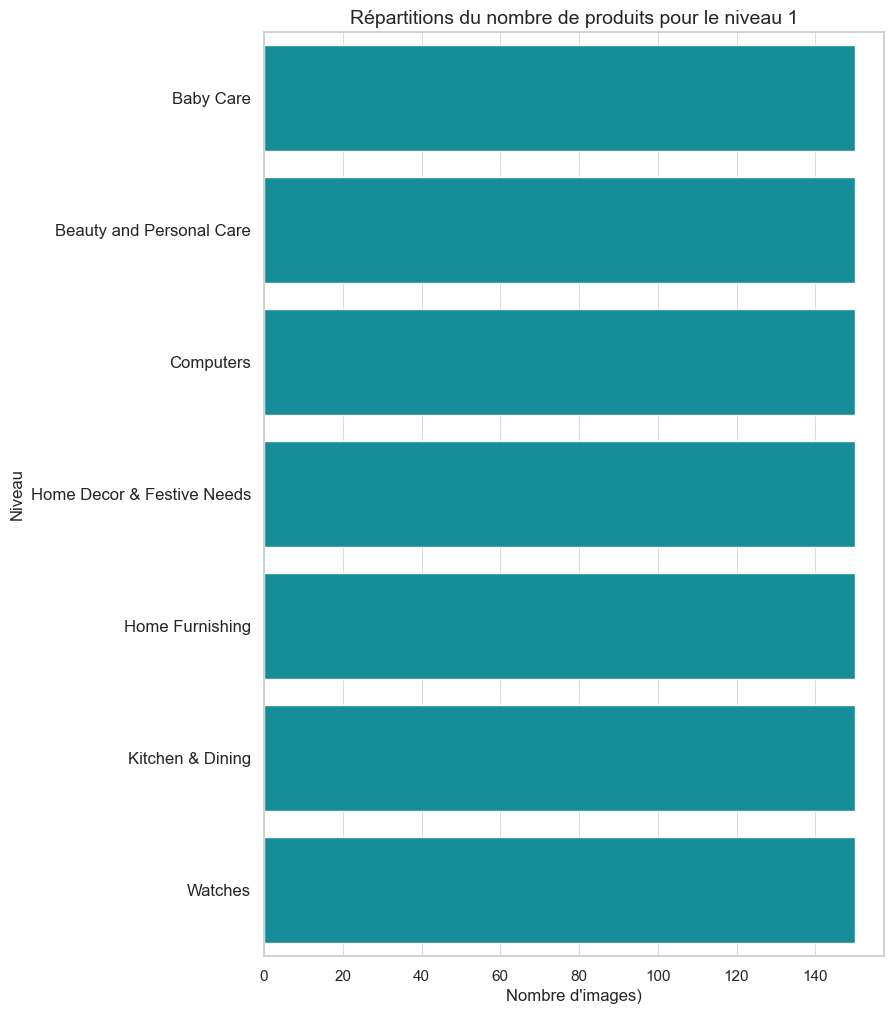

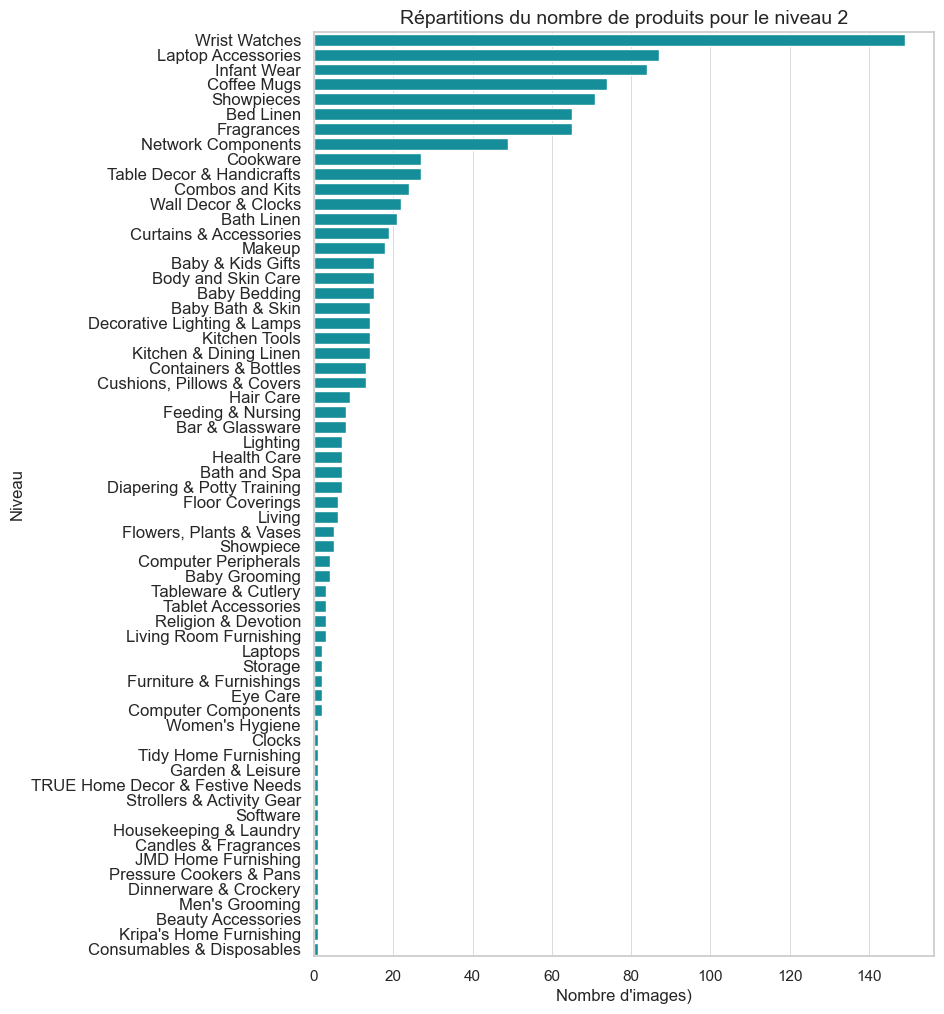

In [13]:
# Définition de la fonction pour tracer le diagramme de répartition des catégories

def plot_category_distribution(df, category_column, title):
    # Regroupement et comptage des produits par catégorie
    df_cat = df.groupby(category_column)[['product_name']].count().sort_values(by='product_name', ascending=False)
    
    # Création de la figure
    plt.figure(figsize=(8, 12))
    
    # Tracé du diagramme à barres
    sns.barplot(y=df_cat.index, x=df_cat.product_name, data=df_cat, color='#00A0B0')
    
    # Configuration du titre et des étiquettes des axes
    plt.title(title, fontsize=14)
    plt.xlabel("Nombre d'images)", fontsize=12) # Nombre d'images = nombre d'article
    plt.ylabel("Niveau", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linewidth=0.5, color='#CCCCCC')
    
    # Affichage du diagramme
    plt.show()

# Itération à travers les niveaux de catégories
for i in range(1, 3): # Je commence par tracer le diagramme pour les deux premiers niveaux pour observer la tendance et savoir s'il est utile de tracer pour tous les niveaux
    # Construction du nom de la colonne de catégorie et du titre
    category_column = 'categorie_niveau_' + str(i)
    title = 'Répartitions du nombre de produits pour le niveau ' + str(i)
    
    # Appel de la fonction pour tracer le diagramme
    plot_category_distribution(data_texte, category_column, title)


Le premier niveau comporte 7 catégories ayant chacune 150 images. Les autres niveaux comportent de nombreuses catégories dont certaines ont moins 10 images, ce qui serait insuffisant pour catégoriser correctement les articles de manière automatique.<br>
Pour la suite, j'utiliserai donc le niveau 1 (7 catégories).

<span style='background:#ef4155'> <font color = "white"> **_Les autres variables_**

Les variables suivantes ne renseignent pas d'informations en lien avec le texte et l'image :
* **retail_price et discounted_price** : indiquent respectivement le prix des articles et le prix après réduction.
* **is_FK_Advantage_product** : booléen dont on ne peut tirer aucune information de texte ou d'image.
* **product_rating et overall_rating** : donnent des informations sur la satisfaction des acheteurs, mais ne donnent aucunes informations directement liées au texte ou à l'image.

Ces variables ne seront pas conservées.

##### <font color = "green"> **2.3. Sélection des variables**

_**Remarque :** les variables "product_name" et "description" renferments des informations similaires. Cependant, la variable "descritption" contenant plus de détails, je ne vais pas conserver la variable "product_name"._

In [14]:
# Suppression des biveaux de catégories non utiles
data_texte.drop(columns = ["categorie_niveau_2", "categorie_niveau_3","categorie_niveau_4",	"categorie_niveau_5","categorie_niveau_6"], inplace = True)

# Renommer la colonne "categorie_niveau_1" en "categorie"
data_texte = data_texte.rename(columns={"categorie_niveau_1": "categorie"})

In [15]:
# Sauvegarde du jeu de données
data_texte.to_csv("data.csv", index = False)

In [16]:

# Sélection des variables pour la suite du travail
data = data_texte[["categorie", "description"]]

# Afficher les 2 premiéres lignes de données
data.head(2)

,categorie,description
0,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."
1,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur..."


In [17]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1050   │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ categorie                 │       0 │          0 │                          2.6 │                     2700 │  │
│ │ description               │       0 │          0 │                          2.6 │                     2700 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

### <font color = "#ef4155"> **II. Prétraitement des données textes :**

#### <font color = "blue"> **1. Normalisation**

A présent, je vais nettoyer les descriptions textuelles en supprimant les caractères spéciaux, la ponctuation, les mots vides (stop words), et en mettant en minuscules les mots. Puis utiliser la méthode de **_lemmatisation_** pour normaliser les mots, ce qui permettra de conserver les informations grammaticales des mots (contrairement au "stemming").

Pour réaliser cette tâche, je vais définir une fonction qui permettra d'appliquer les différentes transformations (tokenisation, lemmatisation) à chaque colonne à l'aide de la fonction apply.

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()

    # Gestion des contractions (ex: didn't -> did not)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    
    # Suppression des caractères spéciaux
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]
    
    # Normalisation numérique
    filtered_tokens = ['NUM' if token.isdigit() else token for token in filtered_tokens]
    
    # Suppression des mots courts
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]
    
    # Élimination de mots rares (facultatif)
    english_words = set(words.words())
    filtered_tokens = [token for token in filtered_tokens if token in english_words]
    
    # Reconstitution du texte prétraité
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Exemple d'utilisation
text = "I can't believe my mentor helped me so much with my NLP tasks!"
preprocessed = preprocess_text(text)
print(preprocessed)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alain\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


believe mentor much task


_Utilisation de la fonction prepreprocess_text pour appliquer  la tokenization, la lemmatisation à chaque variable du jeu de données._

In [19]:
data.loc[data["description"].index, "processed_description"] = data["description"].apply(preprocess_text)

C:\Users\alain\AppData\Local\Temp\ipykernel_4396\1896455036.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
pd.options.display.max_colwidth = 500
data.head(3)

,categorie,description,processed_description
0,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a ...",key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning ...
1,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",specification cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand type bath towel model name cotton bath towel ideal men woman boy girl model color red yellow blue size dimension length inch width inch box number content sale package sale package bath towel
2,Baby Care,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prin...",key feature cotton terry face towel set size small height inch cotton terry face towel set piece face towel set assorted price exclusively designed soft cotton towel export quality product soft texture take care skin give feeling deserve bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cott...


#### <font color = "blue"> **2. Extraction des features texte et analyse**

Je vais mettre en œuvre différentes approches pour transformer les descripteurs textuels en vecteurs numériques : 
* **_Bag-of-Words_** (BoW) 
* **_TF-IDF_** (Term Frequency-Inverse Document Frequency)
* Sentence/embeddings avec **BERT**
* **Universal Sentence Encoder (USE)**
* Et **Word2Vec**

Afin d'évaluer et comparer ces différents modèles avec le score ARI. Créons deux fonctions communes :
- une pour le Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters ;
- une pour la visualisation du Tsne selon les vraies catégories et selon les clusters.

Le nombre d'étiquette à prendre en considération est la taille de la variable "categorie_niveau_1"

In [21]:
def calculate_tsne_and_ari(embeddings, true_labels, num_clusters):
    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)
    
    # Clustering des données
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=300, random_state=42)
    predicted_clusters = kmeans.fit_predict(embeddings)
    
    # Calcul du score ARI entre les vraies étiquettes et les clusters prédits
    ari_score = adjusted_rand_score(true_labels, predicted_clusters)
    
    return tsne_embeddings, predicted_clusters, ari_score

def plot_tsne(tsne_embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    
    # Créationn d'un dictionnaire de correspondance entre les catégories et les valeurs numériques
    category_mapping = {category: index for index, category in enumerate(set(labels))}
    
    # Remplacement des étiquettes de catégorie par les valeurs numériques correspondantes
    labels_numeric = [category_mapping[label] for label in labels]
    
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels_numeric, cmap='hsv', alpha=0.7)
    plt.title(title)
    plt.colorbar()
    plt.show()


<span style='background:#ef4155'> <font color = "white"> **_Bag of Words_**

_Création du modèle Bag of Words pour imprimer la forme du tableau qui comprends les occurences des mots._

In [22]:
# Création d'un objet CountVectorizer
vectoririzer = CountVectorizer()

# Fixation de l'objet CountVectorizer aux données data["processed_description"]
bow_vect = vectoririzer.fit_transform(data["processed_description"])

# Conversion de la matrice BoW en tableau NumPy
bow = bow_vect.toarray()

# Récupération des noms des caractéristiques de l'objet CountVectorizer
bow_ft = vectoririzer.get_feature_names_out()

# Création d'un DataFrame Pandas à partir des données bow et bow_ft
bow_df = pd.DataFrame(bow, columns=bow_ft)

# Imprime la forme du DataFrame bow_df
print(bow_df.shape)

(1050, 3031)


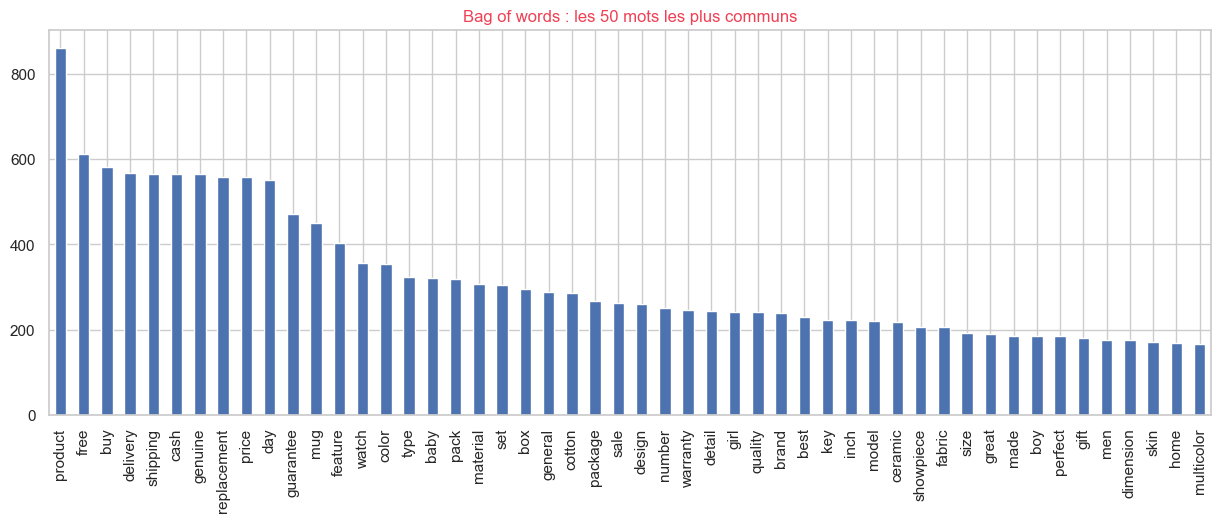

In [23]:
plt.title('Bag of words : les 50 mots les plus communs', color = "#ef4155")
bow_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

_**Réduction de dimension :**_ <br>
_Je vais utiliser la fontion TruncatedSVD (car l'ACP ne supporte pas les matrices creuses) pour réduire les dimensions et le T-sne pour la visualisation en 2D_

In [24]:
print("Dimensions du jeu de données avant réduction TruncatedSVD :", bow_vect.shape)

# Création d'un objet TruncatedSVD avec 100 composantes
svd = TruncatedSVD(n_components=100)


# Application de la réduction TruncatedSVD au vecteur bow_vect
svd_bow = svd.fit_transform(bow_vect)

print("Dimensions dataset après réduction TruncatedSVD : ", svd_bow.shape)

Dimensions du jeu de données avant réduction TruncatedSVD : (1050, 3031)


Dimensions dataset après réduction TruncatedSVD :  (1050, 100)


In [25]:
# Appliquer l'algorithme t-SNE pour réduire la dimension des données
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=50)

# Appliquer t-SNE sur les vecteurs obtenus après la réduction de dimension SVD
tsne_bow = tsne.fit_transform(svd_bow)

# Créer un DataFrame pour stocker les résultats t-SNE et les catégories
df_tsne_bow = pd.DataFrame(tsne_bow[:, 0:2], columns=['tsne1', 'tsne2'])

# Ajouter une colonne "class" au DataFrame contenant les catégories de chaque point
df_tsne_bow["class"] = data["categorie"]

# Afficher les dimensions (nombre de lignes et colonnes) du DataFrame résultant
print(df_tsne_bow.shape)

(1050, 3)


**Calcul du score ARI et visualisation graphique pour le Bag of Words**

Définition d'une fonction pour sauvegarder les résultats du score ARI pour chaque modèle dans un tableau. Ce qui facilitera la comparaison des diiférents modèles.

In [26]:
# Créer un DataFrame vide pour stocker les résultats des modèles et leur score ARI
df_resultats = pd.DataFrame(columns=["model", "ARI"])

def add_model_score(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    # Créer un dictionnaire contenant le nom du modèle et le score ARI
    resultats = dict(model=model_name, ARI=ARI)
    
    # Ajouter des éléments supplémentaires au dictionnaire s'ils sont passés en argument
    resultats = dict(**resultats, **kwargs)
    
    # Créer un DataFrame temporaire contenant les résultats du modèle actuel
    temp_df = pd.DataFrame([[resultats['model'], resultats['ARI']]], columns=['model', 'ARI'])
    
    # Concaténer le DataFrame temporaire avec le DataFrame global
    df = pd.concat([df, temp_df], ignore_index=False)
    
    return df

In [27]:
N_CLUSTERS = 7 # On a 7 catégories produit

In [28]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bow[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0, n_init=10)

# Application de l'algorithme de clustering KMeans sur la matrice X
cls.fit(X)

# Ajout des étiquettes de clusters obtenues au DataFrame df_tsne_tfidf
df_tsne_bow["cluster"] = cls.labels_




# Calcul du score de silhouette pour évaluer la qualité des clusters obtenus
sil = silhouette_score(X, cls.labels_, metric="euclidean")

# Affichage du score de silhouette
print("---------------------------")
print("Le score de silhouette est", round(sil, 2))
print("---------------------------")

---------------------------
Le score de silhouette est 0.52
---------------------------


In [29]:
# Création des labels à partir du nom de catégorie produit
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["categorie"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


C:\Users\alain\AppData\Local\Temp\ipykernel_4396\1094119375.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
labels = data["label"]

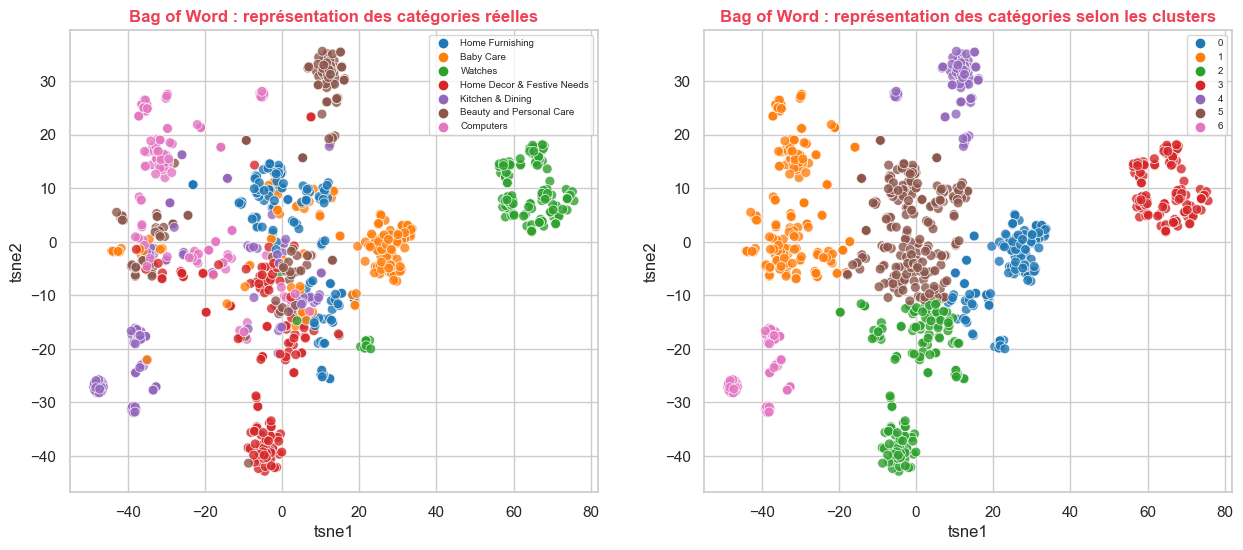

---------------------------
ARI :  0.375
---------------------------


In [31]:
# Créer une figure pour afficher les graphiques
fig = plt.figure(figsize=(15, 6))

# Ajouter le premier sous-graphique à la figure
ax = fig.add_subplot(121)

# Tracé d'un nuage de points t-SNE avec les catégories réelles
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8
)

# Titre et étiquettes des axes pour le premier sous-graphique
plt.title('Bag of Word : représentation des catégories réelles', color="#ef4155", fontsize=12, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 7})

# Ajouter le deuxième sous-graphique à la figure
ax = fig.add_subplot(122)

# Tracé d'un nuage de points t-SNE avec les clusters obtenus
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_bow,
    legend="brief"
)

# Titre et étiquettes des axes pour le deuxième sous-graphique
plt.title('Bag of Word : représentation des catégories selon les clusters', color="#ef4155", fontsize=12, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 7})

# Afficher les graphiques
plt.show()

# Calculer le score ARI pour les clusters obtenus
labels = data["label"]
ARI_bow = round(metrics.adjusted_rand_score(labels, cls.labels_), 3)

# Afficher le score ARI
print("---------------------------")
print(f"ARI : ", ARI_bow)
print("---------------------------")

# Ajouter le score ARI au DataFrame de résultats en utilisant la fonction add_model_score
df_resultats = add_model_score(
    model_name='BOW ', ARI=ARI_bow)

_**Répartition des catégories réelles par cluster**_

In [32]:
def plot_clust_vs_cat(ser_clust, ser_cat, data, figsize=(10, 6),
                      palette='tab10', ylim=(0, 250), bboxtoanchor=None):
    # Créer un DataFrame pivot pour la répartition des catégories par cluster
    pivot = pd.DataFrame()
    pivot['label'] = ser_clust
    pivot['category'] = ser_cat
    pivot['count'] = 1
    pivot = pivot.groupby(by=['label', 'category']).count().unstack().fillna(0)
    pivot.columns = pivot.columns.droplevel()

    # Obtenir une palette de couleurs pour les clusters
    colors = sns.color_palette(palette, ser_clust.shape[0]).as_hex()
    
    # Tracer un graphique en barres empilées pour la répartition des catégories par cluster
    pivot.plot.bar(width=0.8, stacked=True, legend=True, figsize=figsize,
                   color=colors, ec='k')

    # Calculer les pourcentages et afficher les valeurs au-dessus des barres
    row_data = data.shape[0]
    if ser_clust.nunique() > 15:
        font = 8
    else:
        font = 12
    for index, value in enumerate(ser_clust.value_counts().sort_index(ascending=True)):
        percentage = np.around(value / row_data * 100, 1)
        plt.text(index - 0.25, value + 2, str(percentage) + ' %', fontsize=font)

    # Définir les limites de l'axe y et les étiquettes des axes x et y
    plt.gca().set(ylim=ylim)
    plt.xticks(rotation=0)
    plt.xlabel('Clusters', fontsize=14)
    plt.ylabel('Nombre de produits', fontsize=14)
    plt.title('Répartition des vraies catégories par cluster', color="#ef4155",
              fontweight='bold', fontsize=12)

    # Ajouter une légende si bboxtoanchor est spécifié
    if bboxtoanchor is not None:
        plt.legend(bbox_to_anchor=bboxtoanchor)

    # Afficher le graphique
    plt.show()

    # Renvoyer le DataFrame pivot
    return pivot

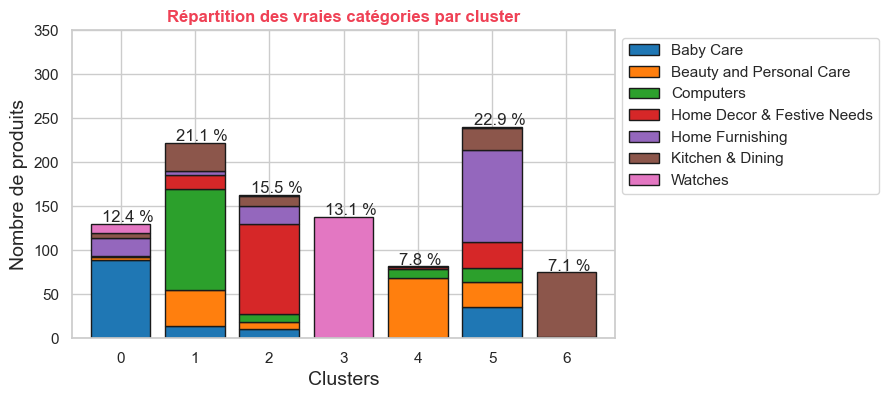

category,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
label,,,,,,,
0,89.0,3.0,0.0,1.0,21.0,6.0,10.0
1,14.0,41.0,115.0,16.0,4.0,32.0,0.0
2,10.0,9.0,9.0,102.0,20.0,12.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,138.0
4,0.0,69.0,10.0,2.0,0.0,1.0,0.0
5,36.0,28.0,16.0,29.0,105.0,25.0,1.0
6,1.0,0.0,0.0,0.0,0.0,74.0,0.0


In [33]:
plot_clust_vs_cat(df_tsne_bow["cluster"], df_tsne_bow["class"], df_tsne_bow, palette='tab10', figsize=(7,4), bboxtoanchor=(1,1), ylim=(0,350))

_**Matrice de confusion**_

In [34]:
def confusion_matrix(y_true, y_pred, title):
    """ 
    Arguments:
        y_true list(str):
        y_pred list(int):
        title (str): 
    """
    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'Labels': y_true, 'Clusters': y_pred})

    # Create crosstab: ct
    ct = pd.crosstab(df['Labels'], df['Clusters'])

    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.heatmap(ct.T, square=True, annot=True, annot_kws={"size": 10},fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False, ax=ax)

    ax.set_title(title, fontsize=12, color = "#ef4155", fontweight = "bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10)
    ax.set_ylabel("clusters", fontsize = 10)
    ax.set_xlabel("labels", fontsize=10)

    plt.show()

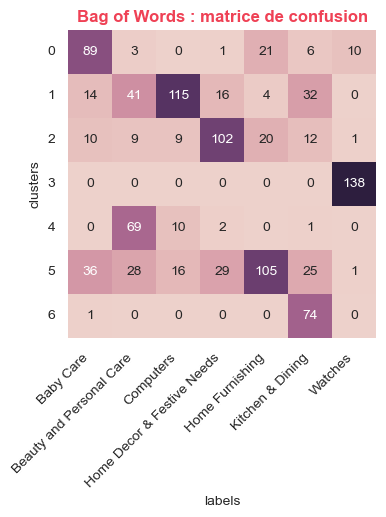

In [35]:
confusion_matrix(df_tsne_bow["class"], df_tsne_bow["cluster"], "Bag of Words : matrice de confusion")

Les catégories "Wacthes" et "Beauty" sont bien prédites, contrairement aux autres catégories.

<span style='background:#ef4155'> <font color = "white"> **_TF-IDF_**

In [36]:
tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(data['processed_description']).toarray()
tfidf_vect.shape

(1050, 3031)

In [37]:
# Dataframe in TF-IDF form
tokens = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_vect, columns=tokens)
print(tfidf_df.shape)


(1050, 3031)


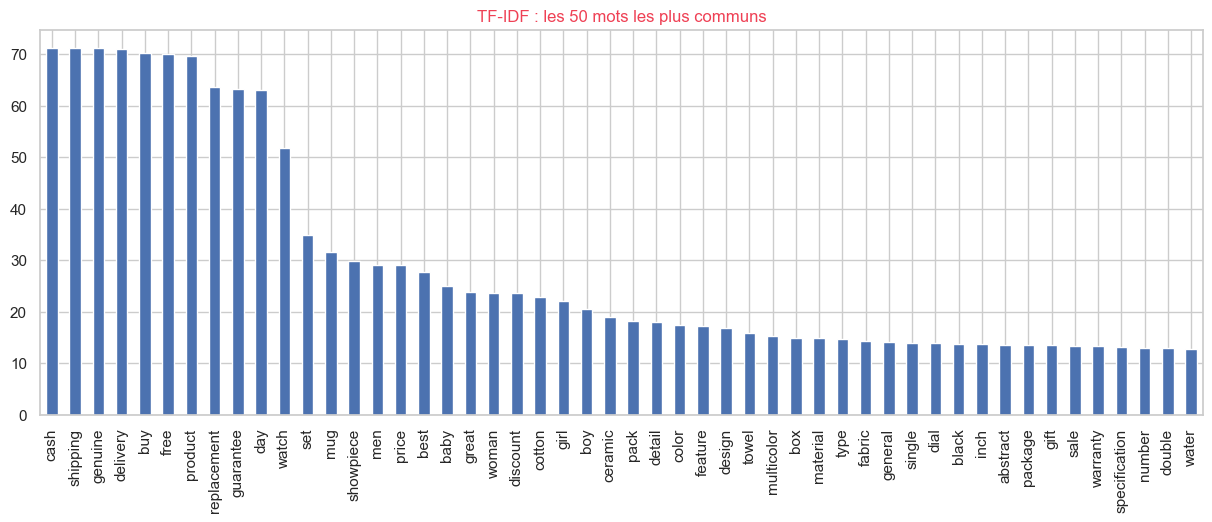

In [38]:
plt.title("TF-IDF : les 50 mots les plus communs", color = "#ef4155")
tfidf_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

_**Réduction de dimension :**_ <br>
_Je vais utiliser l'ACP pour réduire les dimensions et le T-sne pour la visualisation en 2D_

In [39]:
# Afficher les dimensions du jeu de données avant la réduction PCA
print("Dimensions du jeu de données avant réduction PCA : ", tfidf_vect.shape)

# Appliquer la réduction PCA pour réduire la dimension du jeu de données
pca = PCA(n_components=0.99)  # Réduire la dimension en conservant 99% de la variance
pca_results_tfidf = pca.fit_transform(tfidf_vect)

# Afficher les dimensions du jeu de données après la réduction PCA
print("Dimensions du jeu de données après réduction PCA : ", pca_results_tfidf.shape)

Dimensions du jeu de données avant réduction PCA :  (1050, 3031)
Dimensions du jeu de données après réduction PCA :  (1050, 631)


_**Calcul du score ARI et visualisation graphique pour TF-IDF**_

_T-SNE_

In [40]:
# Appliquer l'algorithme t-SNE pour réduire davantage la dimension
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=50)
tsne_results_tfidf = tsne.fit_transform(pca_results_tfidf)

# Créer un DataFrame pour stocker les résultats t-SNE et les catégories
df_tsne_tfidf = pd.DataFrame(tsne_results_tfidf[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = data["categorie"]

# Afficher les dimensions du DataFrame résultant
print(df_tsne_tfidf.shape)

(1050, 3)


In [41]:
df_tsne_tfidf

,tsne1,tsne2,class
0,0.106441,-20.864038,Home Furnishing
1,-1.969768,-37.313438,Baby Care
2,-1.164745,-34.547321,Baby Care
3,15.096677,-23.515465,Home Furnishing
4,15.688087,-23.600895,Home Furnishing
...,...,...,...
1045,12.140966,6.717048,Baby Care
1046,11.168390,6.048000,Baby Care
1047,-24.562670,-4.531083,Baby Care
1048,-22.438183,-5.965833,Baby Care


_Préaparation du clustering_

In [42]:
# Création d'une matrice X à partir des dimensions t-SNE pour l'algorithme de clustering
X = df_tsne_tfidf[["tsne1", "tsne2"]]

# Création d'une instance de l'algorithme de clustering KMeans avec les paramètres spécifiés
cls_tfidf = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10)

# Application de l'algorithme de clustering KMeans sur la matrice X
cls_tfidf.fit(X)

# Ajout des étiquettes de clusters obtenues au DataFrame df_tsne_tfidf
df_tsne_tfidf["cluster"] = cls_tfidf.labels_

# Calcul du score de silhouette pour évaluer la qualité des clusters obtenus
sil = silhouette_score(X, cls_tfidf.labels_, metric="euclidean")

# Affichage du score de silhouette
print("---------------------------")
print("Le score de silhouette est", round(sil, 2))
print("---------------------------")

---------------------------
Le score de silhouette est 0.47
---------------------------


_Visualisation_

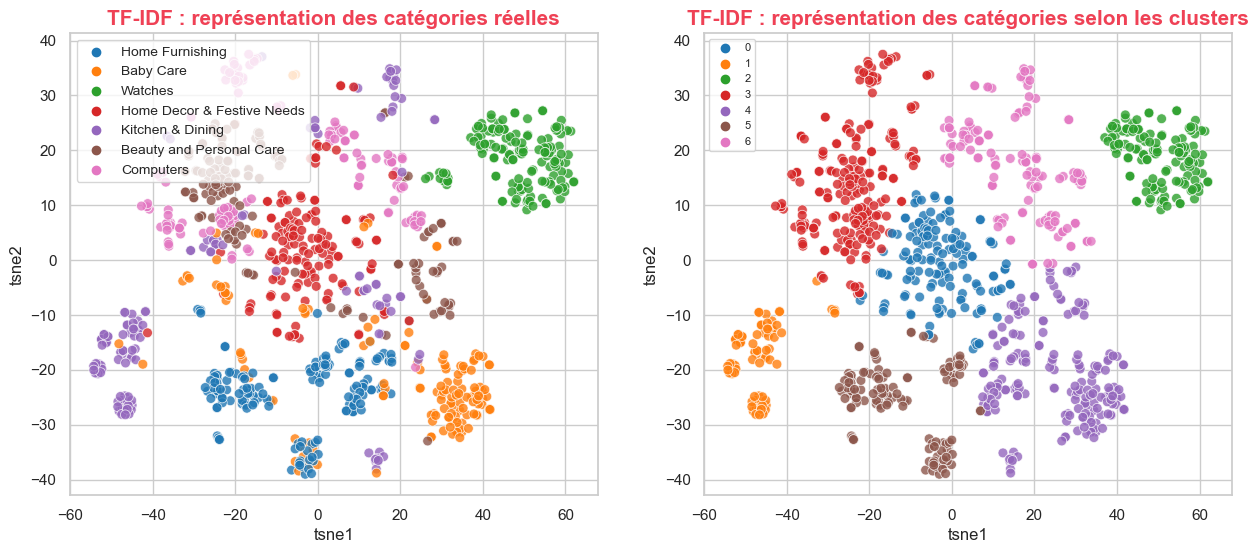

---------------------------
ARI :  0.429
---------------------------


In [43]:
# Créer une figure pour afficher les graphiques
fig = plt.figure(figsize=(15, 6))

# Ajouter le premier sous-graphique à la figure
ax = fig.add_subplot(121)

# Tracé d'un nuage de points t-SNE avec les catégories réelles
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8
)

# Titre et étiquettes des axes pour le premier sous-graphique
plt.title("TF-IDF : représentation des catégories réelles", color="#ef4155", fontsize=15, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 10})

# Ajouter le deuxième sous-graphique à la figure
ax = fig.add_subplot(122)

# Tracé d'un nuage de points t-SNE avec les clusters obtenus
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_tfidf,
    legend="brief"
)

# Titre et étiquettes des axes pour le deuxième sous-graphique
plt.title("TF-IDF : représentation des catégories selon les clusters", color="#ef4155", fontsize=15, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8})

# Afficher les graphiques
plt.show()

# Calculer le score ARI pour les clusters obtenus
labels = data["label"]
ARI_tf_idf = round(metrics.adjusted_rand_score(labels, cls_tfidf.labels_), 3)

# Afficher le score ARI
print("---------------------------")
print(f"ARI : ", ARI_tf_idf)
print("---------------------------")

# Ajouter le score ARI au DataFrame de résultats en utilisant la fonction add_model_score
df_resultats = add_model_score(
    model_name='TF-IDF ', ARI=ARI_tf_idf)

_**Répartition des catégories réelles par cluster**_

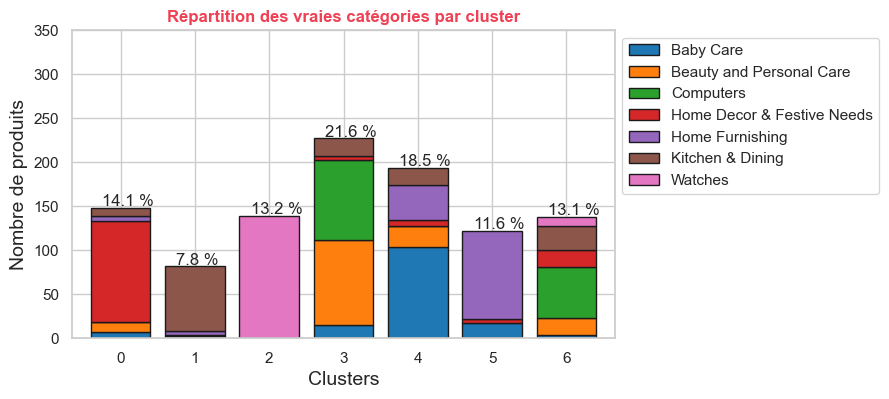

category,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
label,,,,,,,
0,7.0,11.0,1.0,114.0,6.0,9.0,0.0
1,3.0,0.0,0.0,1.0,4.0,74.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,139.0
3,15.0,97.0,90.0,5.0,0.0,20.0,0.0
4,104.0,23.0,1.0,6.0,40.0,20.0,0.0
5,17.0,0.0,0.0,5.0,100.0,0.0,0.0
6,4.0,19.0,58.0,19.0,0.0,27.0,11.0


In [44]:
plot_clust_vs_cat(df_tsne_tfidf["cluster"], df_tsne_tfidf["class"], df_tsne_tfidf,   
                              palette='tab10', figsize=(7,4), bboxtoanchor=(1,1), ylim=(0,350))

_**Matrice de confusion**_

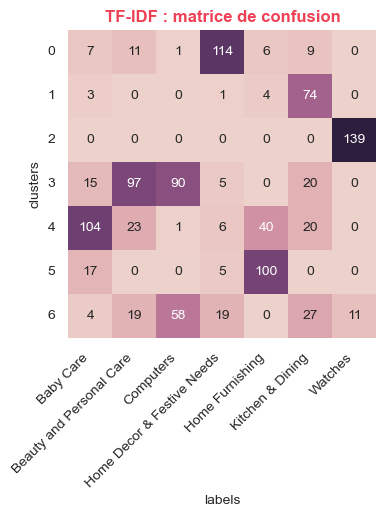

In [45]:
confusion_matrix(df_tsne_tfidf["class"], df_tsne_tfidf["cluster"], "TF-IDF : matrice de confusion")

La catégorie "Watches" est bien prédite, les autres catégories le sont beaucoup moins.

Les scores obtenus avec le BoW et TF-IDF sont très mauvais. Par conséquent, je vais explorer les autres approches et évaluer leurs performances en utilisant la même métriques suivantes.

<span style='background:#ef4155'> <font color = "white"> **_Approche Word/Sentence Embeddings avec BERT_**

<font color = "green"> **BERT HuggingFace (Model "bert-base-uncased")**

In [46]:
data.head(3)

,categorie,description,processed_description,label
0,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a ...",key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning ...,4
1,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",specification cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand type bath towel model name cotton bath towel ideal men woman boy girl model color red yellow blue size dimension length inch width inch box number content sale package sale package bath towel,0
2,Baby Care,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prin...",key feature cotton terry face towel set size small height inch cotton terry face towel set piece face towel set assorted price exclusively designed soft cotton towel export quality product soft texture take care skin give feeling deserve bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary wash care wash cold water iron bleach flat dry wash first use size face towel cott...,0


In [47]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [48]:
import transformers
from transformers import TFAutoModel

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
sentences = data['processed_description'].to_list()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Extraction de caractéristiques BERT à l'aide de la bibliothèque Transformers (Hugging Face)

In [49]:
from transformers import AutoTokenizer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step
temps traitement :  166.0


In [50]:
features_bert.shape

(1050, 768)

_**Réduction de dimension**_ 

In [51]:
# Afficher les dimensions du jeu de données avant la réduction PCA
print("Dimensions du jeu de données avant réduction PCA : ", features_bert.shape)

# Appliquer la réduction PCA pour réduire la dimension du jeu de données
pca = PCA(n_components=0.99)

# Appliquer la réduction PCA
pca_results_bert= pca.fit_transform(features_bert)

# Afficher les dimensions du jeu de données aprés la réduction PCA
print("Dimensions du jeu de données après réduction PCA : ", pca_results_bert.shape)

Dimensions du jeu de données avant réduction PCA :  (1050, 768)
Dimensions du jeu de données après réduction PCA :  (1050, 261)


In [52]:
# Appliquer l'algorithme t-SNE pour la visualisation des données de Bert
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
tsne_results_bert = tsne.fit_transform(pca_results_bert)

# Créer un DataFrame pour stocker les résultats t-SNE et les catégories
df_tsne_bert = pd.DataFrame(tsne_results_bert[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert["class"] = data["categorie"]

# Visualiser les résultats t-SNE
print(df_tsne_bert.shape)

(1050, 3)


**Calcul du score ARI et visualisation graphique pour BERT**

In [53]:
# Création de clusters à partir du T-SNE 
X = df_tsne_bert[["tsne1","tsne2"]]

cls_bert = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state = 50, n_init=10)
cls_bert.fit(X)

df_tsne_bert["cluster"] = cls_bert.labels_

sil = np.round(silhouette_score(X,cls_bert.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.51
---------------------------


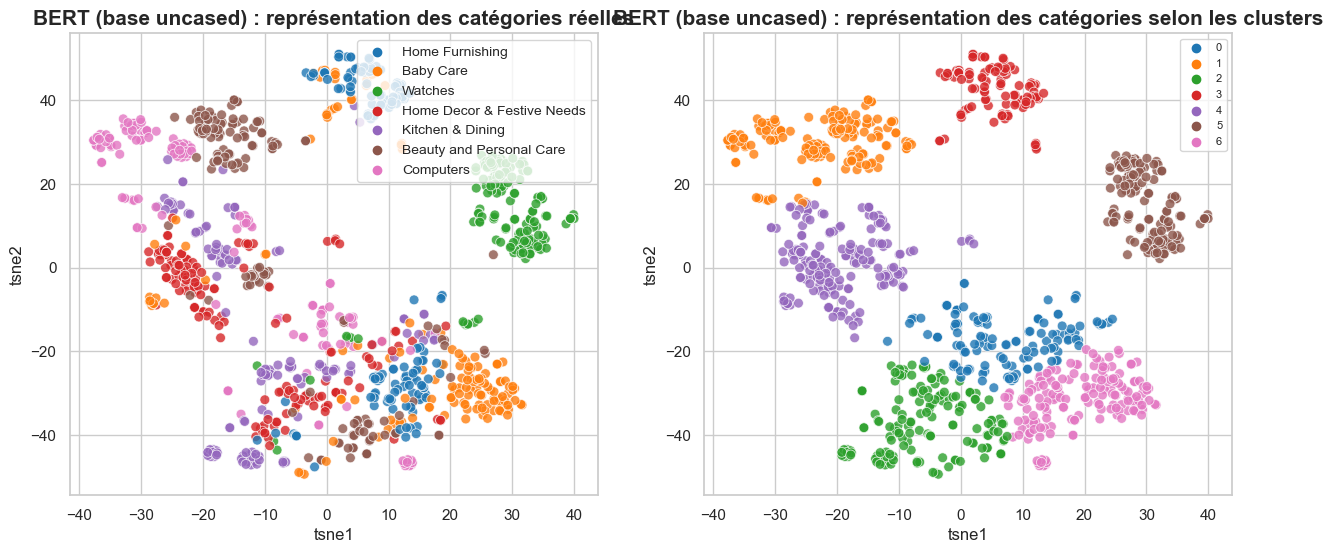

---------------------------
ARI :  0.33
---------------------------


In [54]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('BERT (base uncased) : représentation des catégories réelles', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_bert,legend="brief")

plt.title('BERT (base uncased) : représentation des catégories selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_bert1 =round( metrics.adjusted_rand_score(labels, cls_bert.labels_),3)
labels = data["label"]
print("---------------------------")
print(f"ARI : ",ARI_bert1 )
print("---------------------------")
df_resultats = add_model_score(
    model_name='BERT (bert base uncased) ', ARI=ARI_bert1 )

_**Répartition des catégories réelles par cluster**_

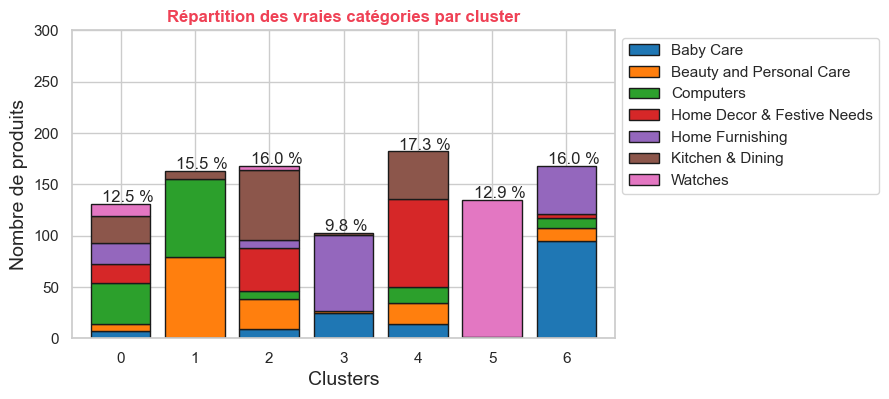

category,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
label,,,,,,,
0,7.0,7.0,40.0,18.0,21.0,26.0,12.0
1,0.0,79.0,76.0,0.0,0.0,8.0,0.0
2,9.0,29.0,8.0,42.0,8.0,68.0,4.0
3,25.0,2.0,0.0,0.0,74.0,2.0,0.0
4,14.0,20.0,16.0,86.0,0.0,46.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,134.0
6,95.0,12.0,10.0,4.0,47.0,0.0,0.0


In [55]:
plot_clust_vs_cat(df_tsne_bert["cluster"],
                              df_tsne_bert["class"],
                              df_tsne_bert,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

_**Matrice de confusion**_

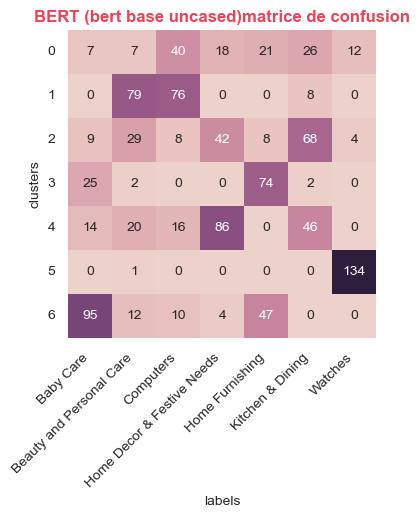

In [56]:
confusion_matrix(df_tsne_bert["class"], df_tsne_bert["cluster"], 'BERT (bert base uncased)matrice de confusion')

Toutes les catégories sont mal prédites avec le BERT Base Uncased : les catégories se confondent.

<font color = "green"> **BERT hub Tensorflow**

In [57]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [58]:
sentences = data['processed_description'].to_list()
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer


Utilisation de BERT avec TensorFlow Hub pour extraire des caractéristiques (features) de phrases. 
* features_bert_hub_Tensorflow contiendra les caractéristiques extraites 
* et last_hidden_states_tot contiendra les états cachés de la dernière couche du modèle BERT.

In [59]:
features_bert_hub_Tensorflow, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  145.0


_**Réduction de dimension**_ 

In [60]:
print("Dimensions dataset avant réduction PCA : ", features_bert_hub_Tensorflow.shape)
pca = PCA(n_components=0.99)
pca_results_bert_hub_Tensorflow= pca.fit_transform(features_bert_hub_Tensorflow)
print("Dimensions dataset après réduction PCA : ", pca_results_bert_hub_Tensorflow.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 262)


In [61]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bert_hub_Tensorflow = tsne.fit_transform(pca_results_bert_hub_Tensorflow)

df_tsne_bert_hub_Tensorflow = pd.DataFrame(tsne_results_bert_hub_Tensorflow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert_hub_Tensorflow["class"] = data["categorie"]
print(df_tsne_bert_hub_Tensorflow.shape)

(1050, 3)


_**Visualisation**_

In [62]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bert_hub_Tensorflow[["tsne1","tsne2"]]

cls_bert3 = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0, n_init = 10)
cls_bert3.fit(X)

df_tsne_bert_hub_Tensorflow["cluster"] = cls_bert3.labels_

sil = np.round(silhouette_score(X,cls_bert3.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.51
---------------------------


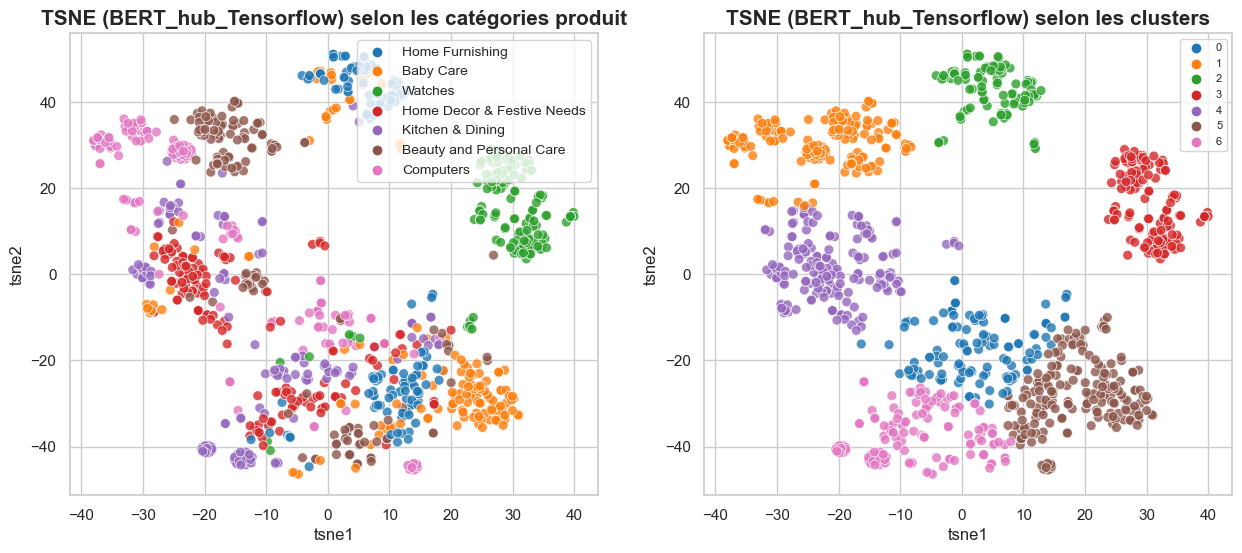

---------------------------
ARI :  0.319
---------------------------


In [63]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert_hub_Tensorflow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT_hub_Tensorflow) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_bert_hub_Tensorflow,legend="brief")

plt.title('TSNE (BERT_hub_Tensorflow) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
ARI_bert3=np.round(metrics.adjusted_rand_score(labels, cls_bert3.labels_),3)

print("---------------------------")
print(f"ARI : ",ARI_bert3)
print("---------------------------")
df_resultats = add_model_score(
    model_name='BERT(hub Tensorflow) ', ARI=ARI_bert3)

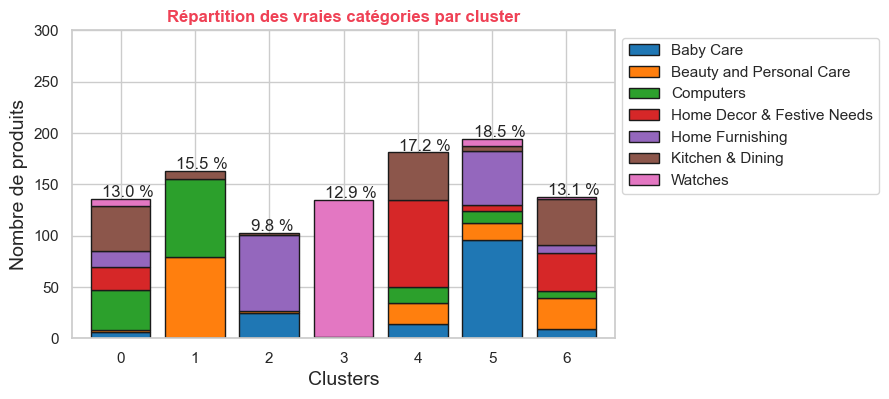

category,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
label,,,,,,,
0,6.0,2.0,39.0,22.0,16.0,44.0,7.0
1,0.0,79.0,76.0,0.0,0.0,8.0,0.0
2,25.0,2.0,0.0,0.0,74.0,2.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,134.0
4,14.0,20.0,16.0,85.0,0.0,46.0,0.0
5,96.0,16.0,12.0,6.0,52.0,5.0,7.0
6,9.0,30.0,7.0,37.0,8.0,45.0,2.0


In [64]:
plot_clust_vs_cat(df_tsne_bert_hub_Tensorflow["cluster"],
                              df_tsne_bert_hub_Tensorflow["class"],
                              df_tsne_bert_hub_Tensorflow,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

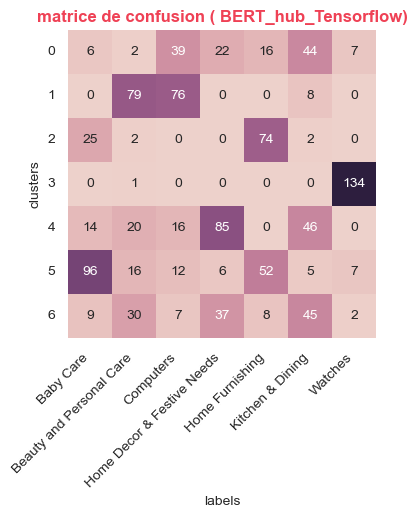

In [65]:
confusion_matrix( df_tsne_bert_hub_Tensorflow["class"],  df_tsne_bert_hub_Tensorflow["cluster"],
                 'matrice de confusion ( BERT_hub_Tensorflow)')

Comme avec le modèle précédent, toutes les catégories sont mal prédites avec le BERT hub Tensorflow : les catégories se confondent.

<span style='background:#ef4155'> <font color = "white"> **_Approche Word/Sentence Embeddings avec Universal Sentence Encoder (USE)_**

In [66]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [67]:
# Fonction d'extraction de caractéristiques à partir d'Universal Sentence Encoder (USE)
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    # Parcours des phrases en lots et extraction des caractéristiques à l'aide d'Universal Sentence Encoder (USE)
    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print(f'feature_USE_fct, time_taken = {time2} s')
    return features

In [68]:
batch_size = 10
sentences = data['processed_description'].to_list()

In [69]:
df_USE = feature_USE_fct(sentences, batch_size)

feature_USE_fct, time_taken = 49.0 s


In [70]:
print("Dimensions dataset avant réduction PCA : ", df_USE.shape)
pca = PCA(n_components=0.99)
pca_results_USE= pca.fit_transform(df_USE)
print("Dimensions dataset après réduction PCA : ", pca_results_USE.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 260)


In [71]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bert_hub_Tensorflow = tsne.fit_transform(pca_results_USE)

df_tsne_results_USE = pd.DataFrame(tsne_results_bert_hub_Tensorflow [:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_results_USE["class"] = data["categorie"]
print(df_tsne_results_USE.shape)

(1050, 3)


In [72]:
#Création de clusters à partir du T-SNE 
X = df_tsne_results_USE[["tsne1","tsne2"]]

cls_use = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0, n_init = 10)
cls_use.fit(X)

df_tsne_results_USE["cluster"] = cls_use.labels_

sil = np.round(silhouette_score(X,cls_use.labels_,metric="euclidean"),2)
print("---------------------------")
print("Le score de silhouette est", sil)
print("---------------------------")

---------------------------
Le score de silhouette est 0.54
---------------------------


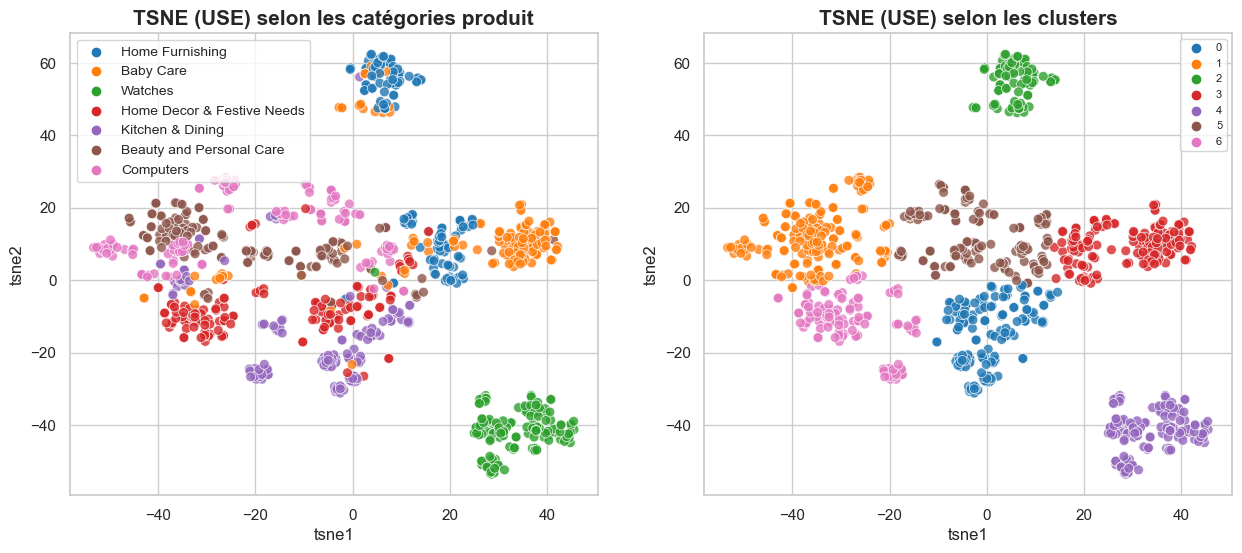

---------------------------
ARI :  0.428
---------------------------


In [73]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_results_USE, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (USE) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_results_USE,legend="brief")

plt.title('TSNE (USE) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
ARI_use=np.round(metrics.adjusted_rand_score(labels, cls_use.labels_),3)

print("---------------------------")
print(f"ARI : ",ARI_use)
print("---------------------------")
df_resultats = add_model_score(
    model_name='USE ', ARI=ARI_use)

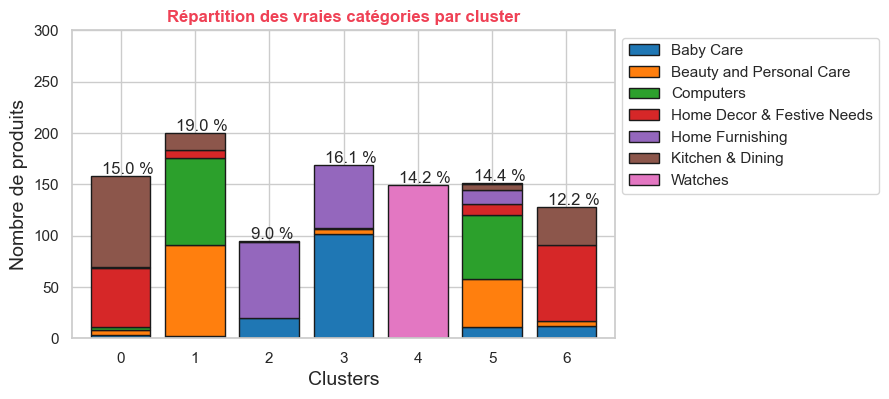

category,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
label,,,,,,,
0,3.0,5.0,3.0,57.0,1.0,89.0,0.0
1,2.0,89.0,85.0,7.0,0.0,17.0,0.0
2,20.0,0.0,0.0,0.0,74.0,1.0,0.0
3,102.0,4.0,0.0,1.0,62.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,149.0
5,11.0,47.0,62.0,11.0,13.0,6.0,1.0
6,12.0,5.0,0.0,74.0,0.0,37.0,0.0


In [74]:
plot_clust_vs_cat(df_tsne_results_USE["cluster"],
                              df_tsne_results_USE["class"],
                              df_tsne_results_USE,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

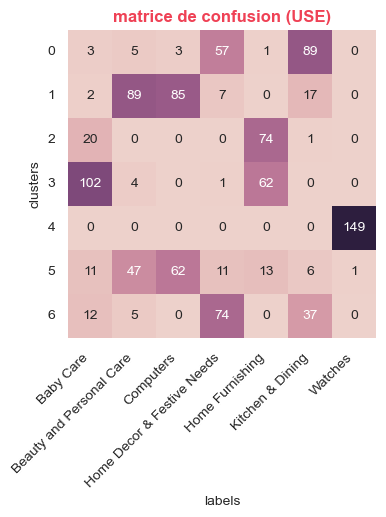

In [75]:
confusion_matrix( df_tsne_results_USE["class"],  df_tsne_results_USE["cluster"],
                 'matrice de confusion (USE)')

Seule la catégorie Watches est bien prédite.

_conversion des embeddings USE en une matrice à 2 dimension_

<span style='background:#ef4155'> <font color = "white"> **_Approche Word Embeddings avec Word2Vec_**

**_Création du modèle d'embedding_**

In [76]:
# Préparation des données 
sentences = data['processed_description'].str.split()

In [77]:
# Entraînement du modèle Word2Vec
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=0)  # Les paramètres peuvent être ajustés

In [78]:
# Transformation des phrases en vecteurs de phrases moyens
def get_sentence_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if not word_vectors:
        return None
    return np.mean(word_vectors, axis=0)

In [79]:
# Transformation des phrases en vecteurs de phrases moyens à l'aide du modèle Word2Vec
sentence_vectors = [get_sentence_vector(sentence, model_w2v) for sentence in sentences]

# Supprimer les vecteurs nuls (si certains mots ne sont pas présents dans le modèle Word2Vec)
sentence_vectors = [vec for vec in sentence_vectors if vec is not None]

# Convertir la liste de vecteurs de phrases en un tableau NumPy
features_w2v = np.array(sentence_vectors)

In [80]:
# Réduction de dimension avec PCA
pca = PCA(n_components=0.99)
pca_results_w2v = pca.fit_transform(features_w2v)

In [81]:
# T-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
tsne_results_w2v = tsne.fit_transform(pca_results_w2v)

In [82]:
# Clustering avec KMeans
X = tsne_results_w2v
cls_w2v = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=50, n_init=10)
cls_w2v.fit(X)

KMeans(n_clusters=7, n_init=10, random_state=50)

In [83]:
# Création d'un DataFrame pour la visualisation
df_tsne_w2v = pd.DataFrame(tsne_results_w2v, columns=['tsne1', 'tsne2'])
df_tsne_w2v["class"] = data["categorie"]

In [84]:
# Ajouter la colonne "cluster" au DataFrame df_tsne_w2v
df_tsne_w2v["cluster"] = cls_w2v.labels_

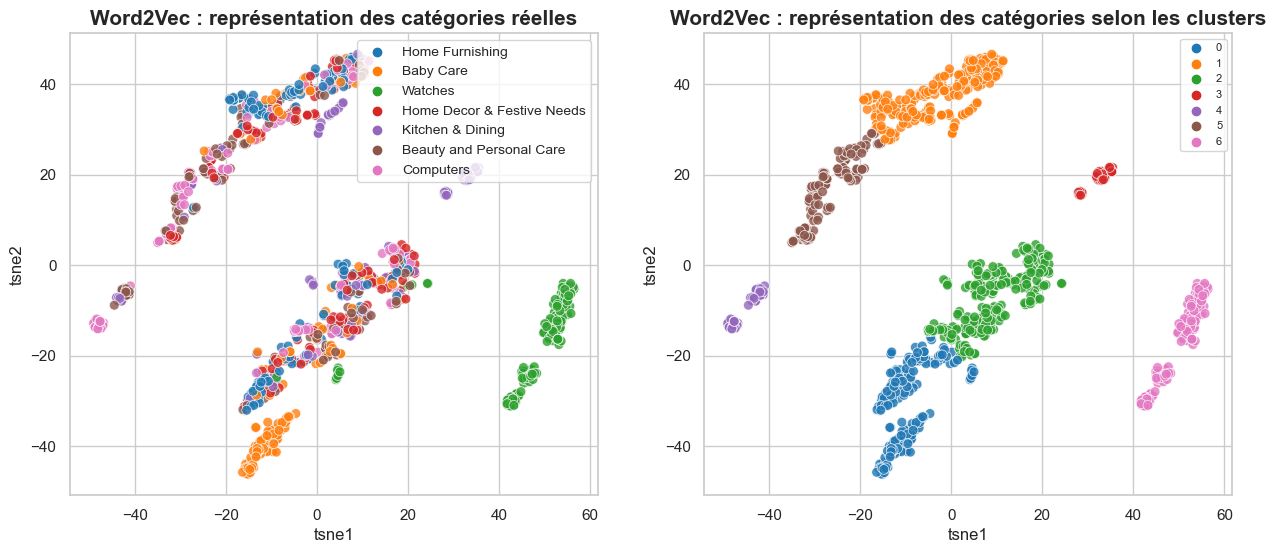

---------------------------
Le score ARI est 0.205
---------------------------


In [85]:
# Affichage des résultats
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_w2v, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8
)
plt.title('Word2Vec : représentation des catégories réelles', fontsize=15, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 10})

ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_w2v, legend="brief"
)
plt.title('Word2Vec : représentation des catégories selon les clusters', fontsize=15, fontweight='bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8})

plt.show()

# Calcul du score ARI
labels = data["label"]  
ari_w2v = round(adjusted_rand_score(labels, cls_w2v.labels_), 3)
print("---------------------------")
print("Le score ARI est", ari_w2v)
print("---------------------------")

# Ajout du score ARI dans le dataframe des résultats
df_resultats = add_model_score(model_name='Word2Vec', ARI=ari_w2v)

In [86]:
# Calcul du score de silhouette
sil_w2v = np.round(silhouette_score(X, cls_w2v.labels_, metric="euclidean"), 2)
print("---------------------------")
print("Le score de silhouette est", sil_w2v)
print("---------------------------")

---------------------------
Le score de silhouette est 0.59
---------------------------


_**Matrice de confusion_**

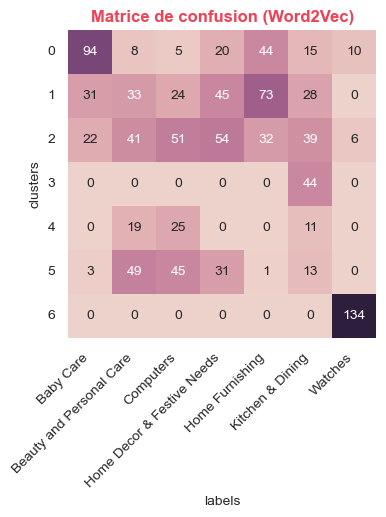

In [87]:
confusion_matrix( df_tsne_w2v["class"],  df_tsne_w2v["cluster"], 'Matrice de confusion (Word2Vec)')

Seule la catégorie Watches est bien prédite.

## <font color = "#ef4155"> **Conclusion**

In [88]:
df_resultats

,model,ARI
0,BOW,0.375
0,TF-IDF,0.429
0,BERT (bert base uncased),0.330
0,BERT(hub Tensorflow),0.319
0,USE,0.428
0,Word2Vec,0.205


Aucune approche n'a permis d'obtenir de bons résultats. Pour chaque modèle testé, le score ARI est faible (inférieur à 0,5). <br> Les approches "TF-IDF" et "USE" ont fournis les scores ARI les plus élevés, soit 0,4. 

Par conséquent, la catégorisation des articles à partir de leur description est possible, mais le risque de confondre les catégories est trop important.

_Sauvegarde du dataframe TF-IDF_

In [89]:
# Sauvegarde des données réduit du meilleur modèle TF-IDF
np.savetxt('pca_results_tfidf.csv', pca_results_tfidf, delimiter=',', fmt='%.18e')